# List of constraints

In [1]:
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_2664440/966458967.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.as_tensor([1, 0.5, -0.5, 0, 0], dtype=TORCH_DTYPE)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y, T, X, _, p_t, _ = data.sample(4000)

In [4]:
ipw = cri.estimators.IPWEstimator().fit(Y, T, X, p_t, policy).predict()
true_ipw = data.evaluate_policy(policy)
true_lower_bound = data.evaluate_policy_lower_bound(policy, Gamma=1.5)
bias = ipw - true_ipw


def remove_finite_sample_bias(ests):
    return [x - bias for x in ests]

In [5]:
MAX_GAMMA = {
    "KL": 0.02,
    "inverse_KL": 0.04,
    "squared_Hellinger": 0.01,
    "Pearson_chi_squared": 0.06,
    "Neyman_chi_squared": 0.03,
    "total_variation": 0.015,
}

In [6]:
def plot_bound_tightness(const_type):
    def get_lower_bound_ci(gamma):
        estimator = cri.estimators.KCMCEstimator(const_type=const_type, gamma=gamma, D=30)
        estimator.fit(Y, T, X, p_t, policy)
        return estimator.predict_ci()

    def get_upper_bound_ci(gamma):
        estimator = cri.estimators.KCMCEstimator(const_type=const_type, gamma=gamma, D=30)
        estimator.fit(-Y, T, X, p_t, policy)
        low, high = estimator.predict_ci()
        return -high, -low

    gammas = [(i / 10) * MAX_GAMMA[const_type] for i in range(11)]
    lower_bound_cis = [get_lower_bound_ci(gamma) for gamma in gammas]
    upper_bound_cis = [get_upper_bound_ci(gamma) for gamma in gammas]

    lower_bounds = [(l + h) / 2 for (l, h) in lower_bound_cis]
    upper_bounds = [(l + h) / 2 for (l, h) in upper_bound_cis]
    lower_bound_cis_high = [h for (l, h) in lower_bound_cis]
    upper_bound_cis_high = [h for (l, h) in upper_bound_cis]
    lower_bound_cis_low = [l for (l, h) in lower_bound_cis]
    upper_bound_cis_low = [l for (l, h) in upper_bound_cis]

    lower_line = plt.plot(gammas, lower_bounds, color=tab10(0))[0]
    upper_line = plt.plot(gammas, upper_bounds, color=tab10(0))[0]
    lower_band = plt.fill_between(
        gammas, lower_bound_cis_low, lower_bound_cis_high, color=tab10(0), alpha=0.1
    )
    upper_band = plt.fill_between(
        gammas, upper_bound_cis_low, upper_bound_cis_high, color=tab10(0), alpha=0.1
    )
    plt.legend([(lower_line, upper_line, lower_band, upper_band)], ["KCMC estimator ($D=30$)"])
    plt.xlabel(r"Sensitivity parameter $\gamma$")
    plt.ylabel(r"Policy value")
    plt.savefig(f"fig/list_constraints_{const_type}.pdf")

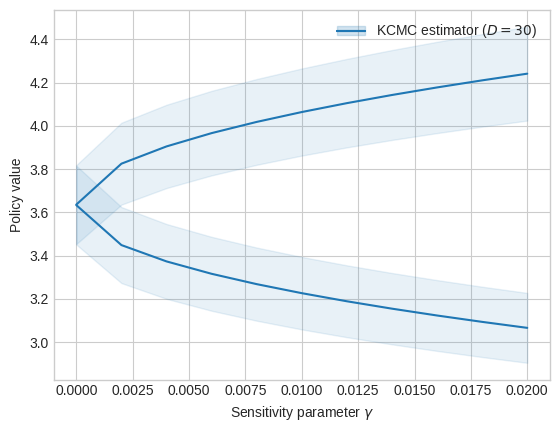

In [7]:
plot_bound_tightness("KL")

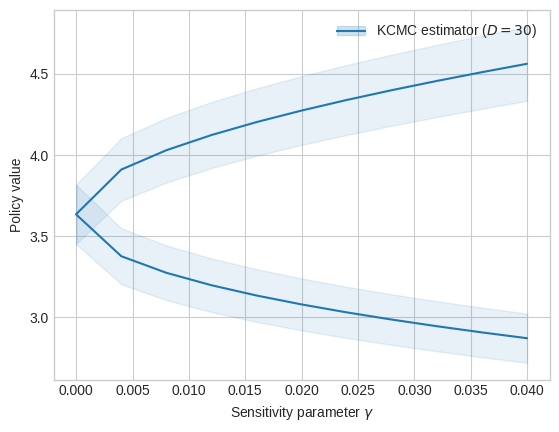

In [8]:
plot_bound_tightness("inverse_KL")

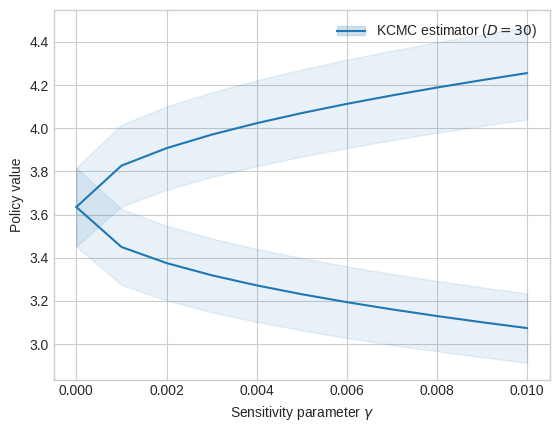

In [9]:
plot_bound_tightness("squared_Hellinger")

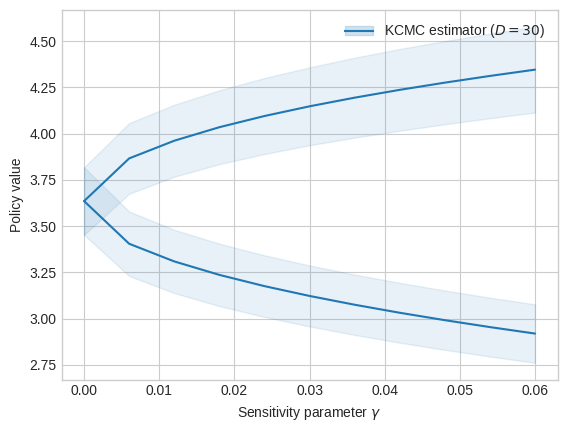

In [10]:
plot_bound_tightness("Pearson_chi_squared")

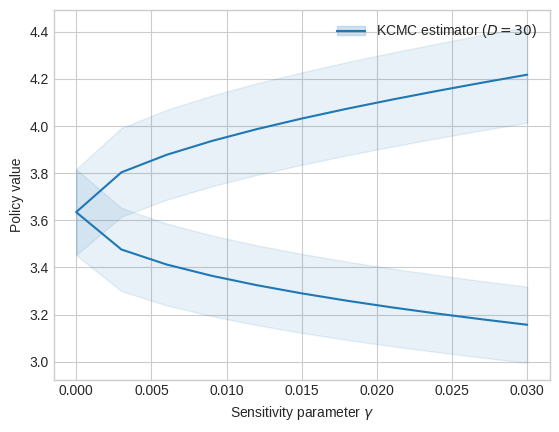

In [11]:
plot_bound_tightness("Neyman_chi_squared")

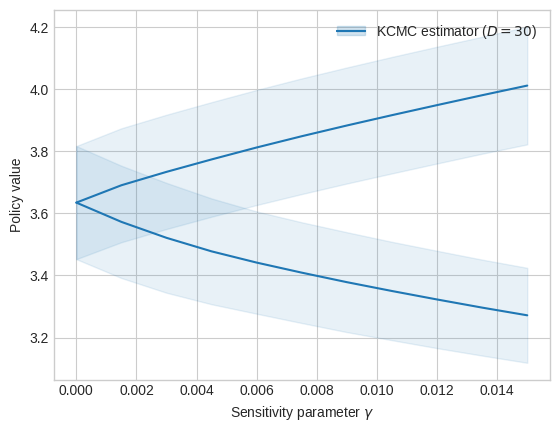

In [12]:
plot_bound_tightness("total_variation")